In [1]:
import cv2
import datetime
import os
import pandas as pd
import numpy as np
import shutil
import seaborn as sns
import random
import math
import tensorflow as tf
import sys
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras import applications, regularizers
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from keras.initializers import he_normal
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import image description data
df_data = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")

df_data2 = df_data.iloc[:, 1:7]

# "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma",

# Daftar kata kunci yang ingin dicari
keywords = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]  # Ganti dengan kata kunci yang diinginkan

# Fungsi untuk mencari kata kunci dalam DataFrame
def search_keywords(data_frame, keyword):
    left_diagnosis = data_frame[data_frame['Left-Diagnostic Keywords'].str.contains(keyword)]
    right_diagnosis = data_frame[data_frame['Right-Diagnostic Keywords'].str.contains(keyword)]
    combined = pd.concat((left_diagnosis['Left-Fundus'], right_diagnosis['Right-Fundus']))

    df_result = pd.DataFrame(combined, columns=['fundus'])
    df_result['class'] = keyword
    return df_result

# Mencari semua kata kunci dalam satu langkah
dfs = []
for keyword in keywords:
    df_keyword = search_keywords(df_data2, keyword)
    dfs.append(df_keyword)

# Menggabungkan hasil pencarian kata kunci
result_df = pd.concat(dfs)

# Menyimpan DataFrame dalam file XLSX
result_df.to_excel('merge.xlsx', index=False)

# Convert DataFrame ke bentuk JSON
data_list = result_df.to_dict(orient='records')


def resize_image(img, target_size):
    # Mendapatkan dimensi gambar asli
    original_height, original_width = img.shape[:2]

    # Mendapatkan dimensi target
    target_width, target_height = target_size

    # Menghitung rasio skala lebar dan tinggi
    width_ratio = target_width / original_width
    height_ratio = target_height / original_height

    # Menentukan rasio skala yang akan digunakan untuk resizing
    scale_ratio = min(width_ratio, height_ratio)

    # Menghitung ukuran baru setelah penskalaan
    new_width = int(original_width * scale_ratio)
    new_height = int(original_height * scale_ratio)

    # Melakukan resizing gambar dengan opsi interporasi yang baik
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Membuat latar belakang gambar dengan ukuran target
    background = (0, 0, 0)  # Hitam

    # Membuat gambar dengan ukuran target yang tepat
    top_padding = (target_height - new_height) // 2
    bottom_padding = target_height - new_height - top_padding
    left_padding = (target_width - new_width) // 2
    right_padding = target_width - new_width - left_padding

    # Menggunakan padding untuk membuat latar belakang dengan ukuran target
    background_img = cv2.copyMakeBorder(resized_img, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=background)

    return background_img

## Read image and preprocessing
def process_images(input_folder, output_folder):
    # Membuat folder output jika belum ada
    os.makedirs(output_folder, exist_ok=True)

    # Loop melalui semua file dalam folder
    for filename in os.listdir(output_folder):

        os.remove(os.path.join(output_folder, filename))

    print("Isi file dalam folder output telah dihapus.")

    # Mendapatkan daftar file gambar di dalam folder input
    image_files = [file for file in os.listdir(input_folder) if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Loop melalui daftar file gambar
    for image_file in tqdm(image_files, desc="Processing images"):
        # Membaca gambar
        image_path = os.path.join(input_folder, image_file)
        image = cv2.imread(image_path)

        # Ubah ukuran gambar
        target_size = (224, 224)  # Ubah ukuran sesuai kebutuhan Anda
#         resized_image = cv2.resize(image, target_size)
        resized_image = resize_image(image, target_size)
        # cropped_image = crop_padding(resized_image)

        # Ubah format warna gambar
        colored_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Simpan gambar ke folder output dengan nama yang sama
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, colored_image)

    print("Proses selesai. Gambar-gambar telah disimpan di folder output.")

# Preprocessing gambar
input_folder = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images"
output_folder = "/kaggle/working/output_preprocessing/"

process_images(input_folder, output_folder)

Isi file dalam folder output telah dihapus.


Processing images: 100%|██████████| 7000/7000 [09:07<00:00, 12.80it/s]

Proses selesai. Gambar-gambar telah disimpan di folder output.


In [3]:
# Folder untuk menyimpan gambar-gambar hasil konversi
output_folder_oversampled = "/kaggle/working/output_oversample/"
output_folder_undersampled = "/kaggle/working/output_undersample/"

# Membuat folder output jika belum ada
os.makedirs(output_folder_oversampled, exist_ok=True)
os.makedirs(output_folder_undersampled, exist_ok=True)

def oversample_images_generator(images, labels):
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    oversampled_images, oversampled_labels = oversampler.fit_resample(images.reshape(len(images), -1), labels)
    for i in range(len(oversampled_images)):
        yield oversampled_images[i].reshape(images.shape[1:]), oversampled_labels[i]

def undersample_images_generator(images, labels):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    undersampled_images, undersampled_labels = undersampler.fit_resample(images.reshape(len(images), -1), labels)
    for i in range(len(undersampled_images)):
        yield undersampled_images[i].reshape(images.shape[1:]), undersampled_labels[i]

tracked_images = []
for df in tqdm(data_list, desc="Tracking image label"):
    fundus = df['fundus']
    file_path = os.path.join(output_folder, fundus)
    image = cv2.imread(file_path)
    if image is not None:
        label = df['class']
        tracked_images.append((image, label))

# Memisahkan gambar dan label menjadi dua list terpisah
tracked_images_list = [(x[0], x[1]) for x in tracked_images]
images_list, labels_list = zip(*tracked_images_list)

unique_classes = np.unique(labels_list)
num_classes = len(unique_classes)
print("Jumlah kelas: ", num_classes)

# Melakukan oversampling
oversampled_images_gen = oversample_images_generator(np.array(images_list), np.array(labels_list))
oversampled_images, oversampled_labels = zip(*oversampled_images_gen)
oversampled_images = list(oversampled_images)
oversampled_labels = list(oversampled_labels)
print("Proses selesai. Gambar telah di oversample.")

# Melakukan undersampling
undersampled_images_gen = undersample_images_generator(np.array(images_list), np.array(labels_list))
undersampled_images, undersampled_labels = zip(*undersampled_images_gen)
undersampled_images = list(undersampled_images)
undersampled_labels = list(undersampled_labels)
print("Proses selesai. Gambar telah di undersample.")

# Fungsi untuk menyimpan gambar ke dalam folder
def save_images(images, labels, output_folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        fundus = f"{label}_{i}.jpg"  # Nama file menggunakan label dan indeks
        file_path = os.path.join(output_folder, fundus)
        cv2.imwrite(file_path, image)

# Menyimpan hasil oversampling
save_images(oversampled_images, oversampled_labels, output_folder_oversampled)

# Menyimpan hasil undersampling
save_images(undersampled_images, undersampled_labels, output_folder_undersampled)

# Fungsi untuk melakukan histogram equalization pada gambar
def histogram_equalization(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Lakukan histogram equalization
    equalized = cv2.equalizeHist(gray)

    equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)

    return equalized

# Fungsi untuk melakukan histogram equalization pada gambar
def clahe(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    enhanced_image = clahe.apply(gray)

    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
    return image

# Folder untuk menyimpan gambar-gambar hasil konversi
output_folder_equalized = "/kaggle/working/output_equalized/"
output_folder_clahe = "/kaggle/working/output_clahe/"

# Membuat folder output jika belum ada
os.makedirs(output_folder_equalized, exist_ok=True)
os.makedirs(output_folder_clahe, exist_ok=True)

# Melakukan histogram equalization pada gambar-gambar hasil oversampling
oversampled_images_copy = list(oversampled_images)  # Buat salinan agar asli tidak berubah
for i in tqdm(range(len(oversampled_images_copy)), desc="CLAHE-ing Images"):
    oversampled_images_copy[i] = clahe(oversampled_images_copy[i])

# Menyimpan hasil histogram equalization
save_images(oversampled_images_copy, oversampled_labels, output_folder_clahe)

# Melakukan histogram equalization pada gambar-gambar hasil oversampling
oversampled_images_copy = list(oversampled_images)  # Buat salinan agar asli tidak berubah
for i in tqdm(range(len(oversampled_images_copy)), desc="Equalizing Images"):
    oversampled_images_copy[i] = histogram_equalization(oversampled_images_copy[i])

# Menyimpan hasil contrast stretching
save_images(oversampled_images_copy, oversampled_labels, output_folder_equalized)

Tracking image label: 100%|██████████| 8470/8470 [00:03<00:00, 2176.55it/s]


Jumlah kelas:  7
Proses selesai. Gambar telah di oversample.
Proses selesai. Gambar telah di undersample.


Equalizing Images: 100%|██████████| 39781/39781 [00:09<00:00, 4119.47it/s]


In [4]:
def split_data(input_folder, output_folder, train_ratio, keywords):
    # Membuat folder output jika belum ada
    os.makedirs(output_folder, exist_ok=True)

    # Hapus konten folder output jika ada
    for filename in os.listdir(output_folder):
        file_path = os.path.join(output_folder, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

    # Daftar semua file gambar dalam folder input
    image_files = [file for file in os.listdir(input_folder) if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Acak urutan file gambar
    random.shuffle(image_files)

    # Tentukan jumlah data training dan testing berdasarkan rasio yang diberikan
    num_train = int(len(image_files) * train_ratio)

    # Bagi data ke dalam folder training dan testing
    train_output_folder = os.path.join(output_folder, 'train')
    test_output_folder = os.path.join(output_folder, 'test')
    os.makedirs(train_output_folder, exist_ok=True)
    os.makedirs(test_output_folder, exist_ok=True)

    # Salin data training dan testing berdasarkan keyword
    for filename in tqdm(image_files[:num_train], desc="Splitting for training data"):
        src_path = os.path.join(input_folder, filename)
        for keyword in keywords:
            if keyword in filename:
                class_name = keyword
                break
        else:
            class_name = "other"

        dst_path = os.path.join(train_output_folder, class_name, filename)
        os.makedirs(os.path.join(train_output_folder, class_name), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for filename in tqdm(image_files[num_train:], desc="Splitting for testing data"):
        src_path = os.path.join(input_folder, filename)
        for keyword in keywords:
            if keyword in filename:
                class_name = keyword
                break
        else:
            class_name = "other"

        dst_path = os.path.join(test_output_folder, class_name, filename)
        os.makedirs(os.path.join(test_output_folder, class_name), exist_ok=True)
        shutil.copy(src_path, dst_path)

    print("Proses split data selesai.")

# Splitting gambar
input_folder = "/kaggle/working/output_clahe/"
output_folder = "/kaggle/working/output_splitting/"
train_ratio = 0.7  # Rasio data training (0.7 = 70% training, 30% testing)

split_data(input_folder, output_folder, train_ratio, keywords)

Splitting for testing data: 100%|██████████| 11935/11935 [00:01<00:00, 7854.25it/s]

Proses split data selesai.


Found 27846 images belonging to 7 classes.
Found 11935 images belonging to 7 classes.
17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7

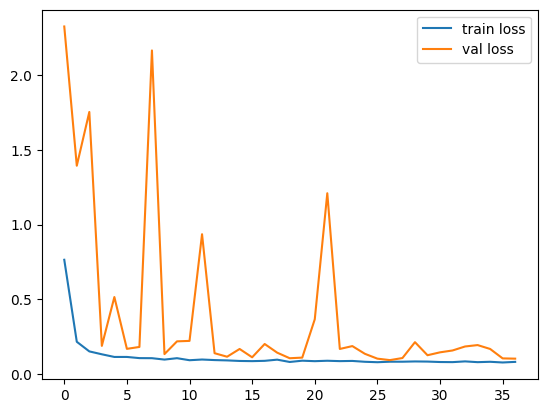

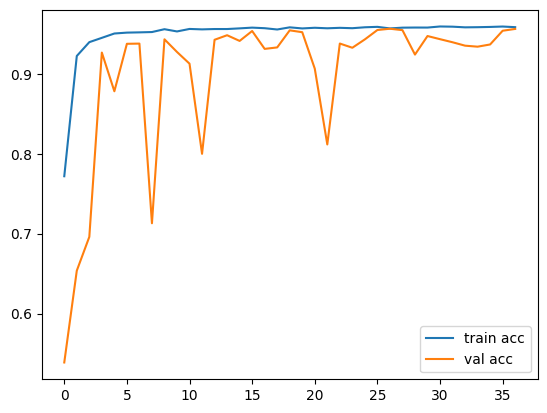

47/47 [==============================] - 24s 502ms/step


<Figure size 640x480 with 0 Axes>

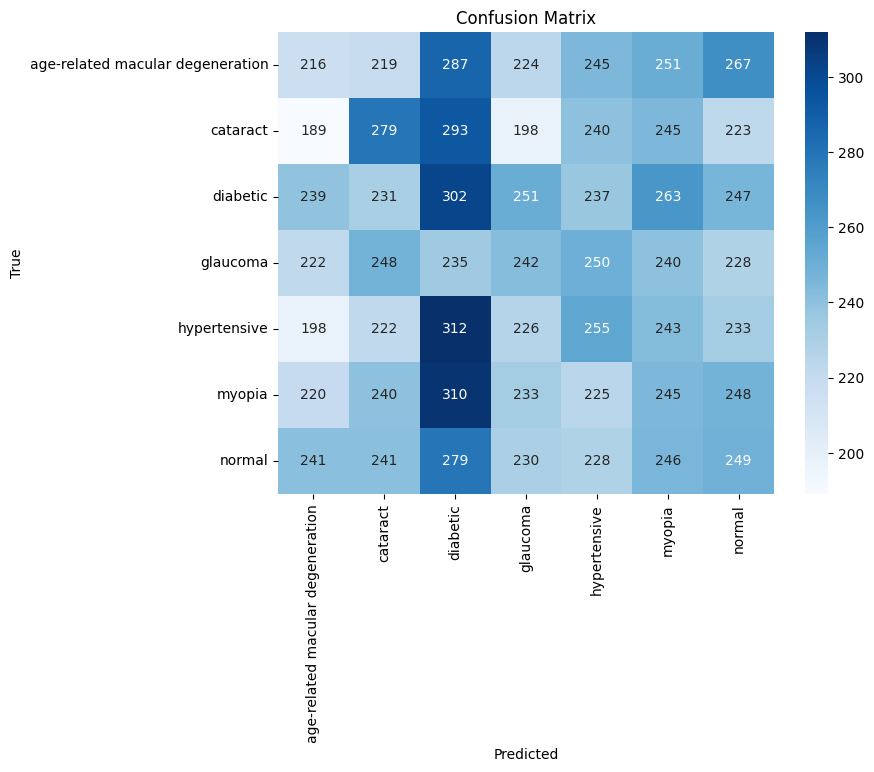

Classification Report:
                                   precision    recall  f1-score   support

age-related macular degeneration       0.14      0.13      0.13      1709
                        cataract       0.17      0.17      0.17      1667
                        diabetic       0.15      0.17      0.16      1770
                        glaucoma       0.15      0.15      0.15      1665
                    hypertensive       0.15      0.15      0.15      1689
                          myopia       0.14      0.14      0.14      1721
                          normal       0.15      0.15      0.15      1714

                        accuracy                           0.15     11935
                       macro avg       0.15      0.15      0.15     11935
                    weighted avg       0.15      0.15      0.15     11935

Class: age-related macular degeneration
  Accuracy: 0.15
  Precision: 0.14
  Recall: 0.13
  F1-Score: 0.13
Class: cataract
  Accuracy: 0.15
  Precision: 0.17
 

<Figure size 640x480 with 0 Axes>

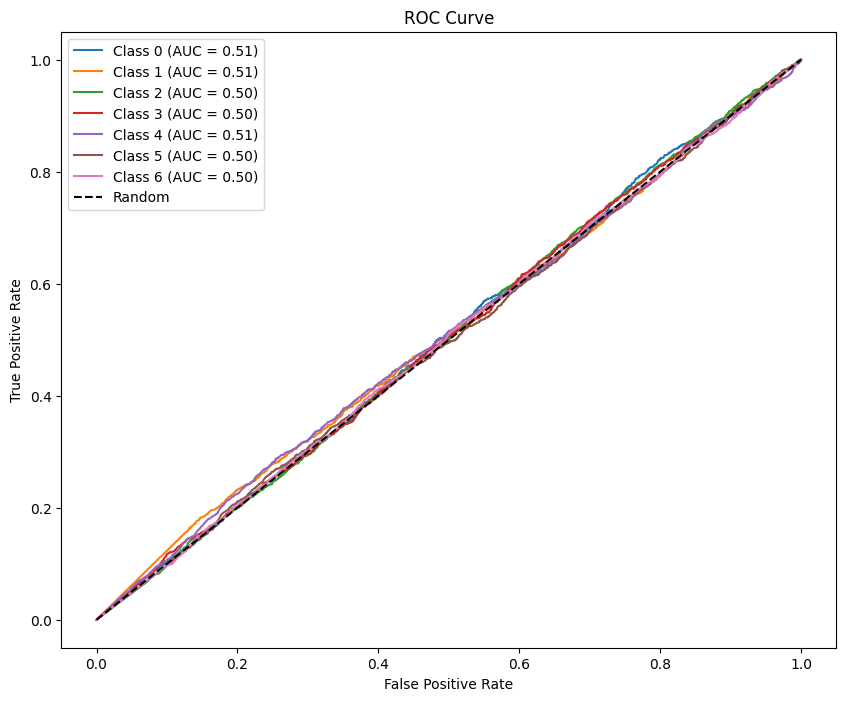

<Figure size 640x480 with 0 Axes>

In [5]:
# Menentukan path untuk data training dan testing
train_data_dir = '/kaggle/working/output_splitting/train/'
test_data_dir = '/kaggle/working/output_splitting/test/'

# Membuat model MobileNet
input_shape = (224, 224, 3)  # Sesuaikan dengan ukuran input MobileNet
num_classes = len(keywords)
batch_size = 256
epochs = 200

# Menentukan generator untuk data tanpa augmentasi
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Membuat generator untuk data training dan testing
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size= batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size= batch_size,
    class_mode='categorical'
)

# MobileNet sebagai base model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Membangun model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Define callbacks
checkpoint_mobilenet = ModelCheckpoint('model.save', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_mobilenet = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
log_dir = "logs/fit_mobilenet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# lr_scheduler = LearningRateScheduler(lr_schedule)  # Learning Rate Scheduler callback

callbacks = [checkpoint_mobilenet, early_stopping_mobilenet, tensorboard_callback]

# Membuat objek optimizer RMSprop dengan kustomisasi parameter
rms_optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)

# Compile model dengan objek optimizer RMSprop yang telah dibuat
model.compile(optimizer=rms_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

# Melatih model tanpa augmentasi data
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=callbacks)

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss.png")

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig("AccVal_acc.png")

# Load best model (model dengan val_accuracy terbaik) jika menggunakan ModelCheckpoint
model = load_model('model.save')

# Evaluasi model pada data uji
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig("Confusion_Matrix.png")

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

# Calculate Accuracy, Precision, Recall, and F1-score from Confusion Matrix
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the values
for i, class_name in enumerate(test_generator.class_indices.keys()):
    print(f'Class: {class_name}')
    print(f'  Accuracy: {accuracy:.2f}')
    print(f'  Precision: {precision[i]:.2f}')
    print(f'  Recall: {recall[i]:.2f}')
    print(f'  F1-Score: {f1_score[i]:.2f}')

# ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=num_classes)[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
plt.savefig("ROC_Curve.png")